In [3]:
pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import random
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tensorboard

In [6]:
class SemiCircumferenceDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=128, num_points=10000):
        super().__init__()
        self.batch_size = batch_size
        self.num_points = num_points

    def setup(self, stage=None):
        angle = torch.rand(self.num_points) * np.pi
        radius = torch.ones(self.num_points)
        x = radius * torch.cos(angle)
        y = radius * torch.sin(angle)
        self.data = torch.stack([x, y], dim=1)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.data, batch_size=self.batch_size, shuffle=True)

In [20]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class EnergyModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, out_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, out_dim),
        )
    
    def forward(self, x):
        return self.model(x).squeeze(dim=-1)

# Remeber that this model's output is not the energy E(x) but -E(x)

In [21]:
class Sampler:
    
    def __init__(self, model, sample_size, max_len=8192):
        super().__init__()
        self.model = model
        self.sample_size = sample_size
        self.max_len = max_len

        # Put everything on the same device that Lightning assigns to the model
        self.device = next(model.parameters()).device

        # Generate points in the interval [-1,1]
        self.examples = [torch.rand((2,), device=self.device) * 2 - 1 for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=0.1):

        # n_new is the number of points that are generated anew, the rest come from last iteration
        n_new = np.random.binomial(self.sample_size, 0.05)
        
        rand_points = (torch.rand((n_new, 2), device=self.device) * 2 - 1)

        # Select k=self.sample_size - n_new points from last iteration (self.examples)
        old_points = torch.stack(random.choices(self.examples, k=self.sample_size - n_new))

        inp_points = torch.cat([rand_points, old_points], dim=0).detach().to(self.device)

        inp_points = Sampler.generate_samples(self.model, inp_points, steps=steps, step_size=step_size)

        # Update the last iteration points with the current iteration ones
        # Place points on the CPU to save GPU memory
        self.examples = list(inp_points.to(torch.device("cpu"))) + self.examples

        # If the points saved are too many discard the old ones
        self.examples = self.examples[:self.max_len]
        
        return inp_points


    @staticmethod
    def generate_samples(model, inp_points, steps=60, step_size=0.1):
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_points.requires_grad = True

        # Generate a noise vector outside the loop so that we don't have to allocate memory 
        # each time we start a new loop iteration
        noise = torch.randn(inp_points.shape, device=inp_points.device)

        for _ in range(steps):

            # the "_" means that this is an in-place operation. We are just modifying the noise vector
            # without allocating new memory
            noise.normal_(0, 0.01)

            '''
            Option 1:
            '''
            inp_points.data.add_(noise.data)

            out_points = -model(inp_points)
            out_points.sum().backward()
            inp_points.grad.data.clamp_(-0.03, 0.03)

            inp_points.data.add_(-step_size * inp_points.grad.data)
            inp_points.grad.detach_()
            inp_points.grad.zero_()
            '''
            inp_points = inp_points + noise
            print(inp_points.requires_grad)
            
            # Since the models compute -E(x) and we want inp_points_energy to be E(x) we need to change sign to the output of model()
            inp_points_energy = -model(inp_points)
            inp_points_energy.sum().backward()
            inp_points.grad.clamp_(-0.03, 0.03)  # Stabilize gradients

            inp_points = inp_points - step_size * inp_points.grad

            # Detatch grads from the computational graph and zero them
            inp_points.grad.detach_()
            inp_points.grad.zero_()
            '''

        for p in model.parameters():
            p.requires_grad = True
        model.train()

        return inp_points


In [22]:
class DeepEnergyModel(pl.LightningModule):
    
    def __init__(self, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, sampler_steps=60, sampler_step_size=0.1, **model_args):
        super().__init__()
        self.save_hyperparameters()

        self.energy_model = EnergyModel(**model_args)
        self.sampler = Sampler(self.energy_model, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, 2)

    def forward(self, x):
        return self.energy_model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        real_points = batch
        small_noise = torch.randn_like(real_points) * 0.005
        real_points.add_(small_noise)

        fake_points = self.sampler.sample_new_exmps(steps=self.hparams.sampler_steps, step_size=self.hparams.sampler_step_size)

        inp_points = torch.cat([real_points, fake_points], dim=0)

        # Get the energy for real samples and fake ones. Since we have the same number of
        # real and fake sample we can just split the resulting vector in 2 equal parts with .chunk
        
        # Remeber that self.energy_model(inp_points) = -E(x) and not E(x)
        real_energy, fake_energy = self.energy_model(inp_points).chunk(2, dim=0)
        
        reg_loss = self.hparams.alpha * (real_energy ** 2 + fake_energy ** 2).mean()

        # The standard form for contrastive loss is E(x^+) - E(x^-) (where x^+ are real samples
        #and x^- are fake samples) because we want to minimize the energy of real samples.
        # In this case the sign is inverted cause real_energy and fake_energy are -E(x^+) 
        # and -E(x^-) respectively
        cdiv_loss = fake_energy.mean() - real_energy.mean()
        loss = reg_loss + cdiv_loss

        self.log('loss', loss, on_epoch=True, prog_bar=True)
        #self.log('loss_regularization', reg_loss, on_epoch=True)
        self.log('loss_contrastive_divergence', cdiv_loss, on_epoch=True, prog_bar=True)
        return loss

    # This validation compares the energy of real points with completely fake points
    def validation_step(self, batch, batch_idx):
        real_points = batch
        fake_points = torch.rand_like(real_points) * 2 - 1

        inp_points = torch.cat([real_points, fake_points], dim=0)
        real_out, fake_out = self.energy_model(inp_points).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        #self.log('val_contrastive_divergence', cdiv, on_epoch=True, prog_bar=True)


    def visualize_samples(self, points, epoch, training_data):
        points = points.cpu().detach().numpy()
        training_data = training_data.cpu().detach().numpy()
    
        plt.figure(figsize=(8, 8))
        # Plot the training data points in blue
        plt.scatter(training_data[:, 0], training_data[:, 1], color='blue', alpha=0.3, label='Training Data')
        # Plot the sampled points in red
        plt.scatter(points[:, 0], points[:, 1], color='red', alpha=0.5, label='Sampled Points')
        
        plt.title(f'Sampled Points at Epoch {epoch}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.xlim(-1.5, 1.5)
        plt.ylim(0, 1.5)
        plt.grid(True)
        plt.legend()
        plt.show()



In [23]:
# This callback generates a plot of the generated samples every n epochs

class VisualizeCallback(pl.Callback):
    def __init__(self, every_n_epochs=5):
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            sampled_points = pl_module.sampler.sample_new_exmps(
                steps=pl_module.hparams.sampler_steps, 
                step_size=pl_module.hparams.sampler_step_size
            )
            pl_module.visualize_samples(sampled_points, epoch=trainer.current_epoch)

visualize_callback = VisualizeCallback(every_n_epochs=5)

In [24]:
# Instantiate DataModule and Model
data_module = SemiCircumferenceDataModule(batch_size=128, num_points=1000)
model = DeepEnergyModel(batch_size=128, lr=1e-4, alpha=0.1, beta1=0.0, input_dim=2, hidden_dim=128, out_dim=1)

from pytorch_lightning.loggers import TensorBoardLogger

# Create a TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="deep_energy_model")

# Create a PyTorch Lightning trainer with the logger
trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=200,
    gradient_clip_val=0.1,
    callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='loss_contrastive_divergence'),
               LearningRateMonitor("epoch"),
               visualize_callback],
    logger=logger  # Add the logger here
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [25]:
# Train the model
trainer.fit(model, datamodule=data_module)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type        | Params | Mode  | In sizes | Out sizes
----------------------------------------------------------------------------
0 | energy_model | EnergyModel | 50.0 K | train | [1, 2]   | [1]      
----------------------------------------------------------------------------
50.0 K    Trainable params
0         Non-trainable params
50.0 K    Total params
0.200     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_worker

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


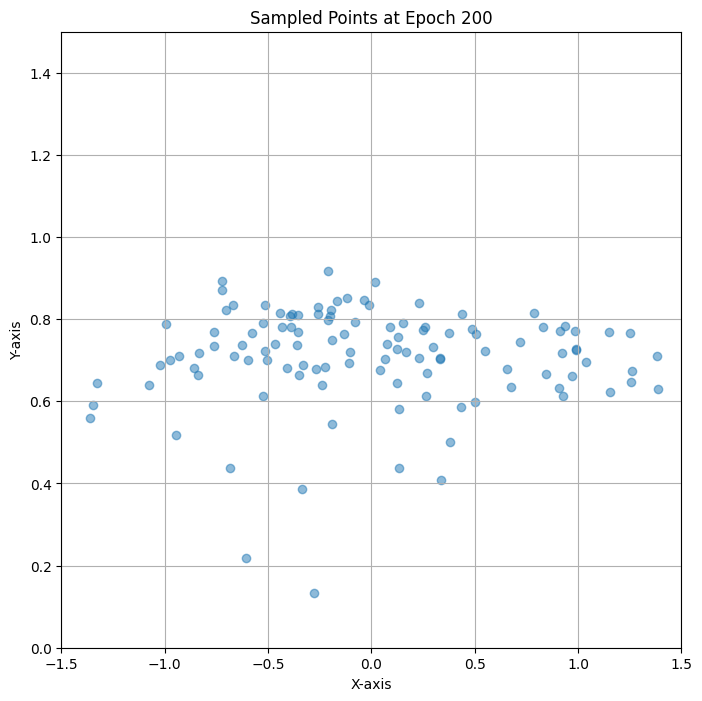

In [26]:
# Visualize some of the sampled points after training
sampled_points = model.sampler.sample_new_exmps(steps=60, step_size=0.1)
model.visualize_samples(sampled_points, epoch=trainer.current_epoch)

In [27]:
%load_ext tensorboard
%tensorboard --logdir tb_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4449), started 0:04:45 ago. (Use '!kill 4449' to kill it.)